#### 模型构建步骤
- 1.初始化网络参数
- 2.前向传播  
2.1 计算一层的中线性求和的部分  
2.2 计算激活函数的部分（ReLU使用 $L-1$ 次，Sigmod使用1次）  
2.3 结合线性求和与激活函数

- 3.计算误差
- 4.反向传播  
4.1 线性部分的反向传播公式  
4.2 激活函数部分的反向传播公式  
4.3 结合线性部分与激活函数的反向传播公式

- 5.更新参数  

对于每个前向函数，都有一个相应的后向函数。 这就是为什么在我们的转发模块的每一步都会在cache中存储一些值，cache的值对计算梯度很有用， 在反向传播模块中，我们将使用cache来计算梯度

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# 加载外部 .py文件
import testCases4 
import lr_utils 

np.random.seed(1)

#### 模型构建
##### 初始化多层网络的参数
与两层网络相比，要除以/ np.sqrt(layers_dims[l - 1])而不是乘以0.01，这样做的目的是为了防止（深度神经网络）出现梯度消失或梯度爆炸

In [3]:
def initialize_parameters(layers_dims):
    """
    初始化所有层的参数，包括输入层和隐藏层之间，隐藏层和输出层之间。
    参数：
        layers_dims - 每层神经元数量的列表，分别为 输入层、隐藏层、输出层
    """
    np.random.seed(3)
    parameters = {}
    
    # 第一个是输入层的神经元数量，所以计算神经网络的层数时要减一
    n_layers = len(layers_dims) - 1 
    
    for l in range(1, n_layers+1):
        # l 对应 layer_dims 的第 l+1 个元素
        parameters["W" + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1]) / np.sqrt(layers_dims[l - 1]) 
        parameters["b" + str(l)] = np.zeros((layers_dims[l], 1))
        
        # 确保数据的格式是正确的
        assert(parameters["W" + str(l)].shape == (layers_dims[l], layers_dims[l-1]))
        assert(parameters["b" + str(l)].shape == (layers_dims[l], 1))
        
    return parameters

测试一下，确实是两层网络的参数，shape也对

In [8]:
print("==============测试initialize_parameters==============")
layers_dims = [5, 4, 1]
parameters = initialize_parameters(layers_dims)

for key, value in parameters.items():
    print(key)
    print(value)
    print(value.shape)
    print('\n')

==============测试initialize_parameters==============
W1
[[ 0.79989897  0.19521314  0.04315498 -0.83337927 -0.12405178]
 [-0.15865304 -0.03700312 -0.28040323 -0.01959608 -0.21341839]
 [-0.58757818  0.39561516  0.39413741  0.76454432  0.02237573]
 [-0.18097724 -0.24389238 -0.69160568  0.43932807 -0.49241241]]
(4, 5)


b1
[[0.]
 [0.]
 [0.]
 [0.]]
(4, 1)


W2
[[-0.59252326 -0.10282495  0.74307418  0.11835813]]
(1, 4)


b2
[[0.]]
(1, 1)




##### 前向传播

###### 激活函数的定义

In [11]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

In [12]:
def relu(Z):
    return np.maximum(0, Z)

In [ ]:
def tanh():
    pass

###### 单层网络的前向传播

In [75]:
def forward(A_last, W, b, activation):
    """
    根据上一层（l-1）的线性输出A_last 和本层的参数 W,b，计算出本层（l）的线性输出 Z 和激活 A
    返回：
         cache - 元组，包含 元组linear_cache：（上一层的线性输出 A_last，以及本层的参数 W（不需要保存b），
                     和 元素 activation_cache（本层的线性输出 Z）， 用于反向传播
    """
    
    if activation == "sigmoid":
        Z = np.dot(W, A_last) + b
        A = sigmoid(Z)        
    elif activation == "relu":
        Z = np.dot(W, A_last) + b
        A = relu(Z)
    
    assert(A.shape == (W.shape[0], A_last.shape[1]))
    
    linear_cache = (A_last, W, b)
    activation_cache = Z
    cache = (linear_cache, activation_cache)
    
    return A, cache

In [16]:
print("==============测试linear_activation_forward==============")
A_last, W, b = testCases4.linear_activation_forward_test_case()

A, cache = forward(A_last, W, b, activation="sigmoid")
print("sigmoid，A = " + str(A)) # 取值介于0和1之间

A, cache = forward(A_last, W, b, activation="relu")
print("ReLU，A = " + str(A)) # 取值大于等于0

==============测试linear_activation_forward==============
sigmoid，A = [[0.96890023 0.11013289]]
ReLU，A = [[3.43896131 0.        ]]


###### 多层网络的前向传播
基于单层线性输出和激活函数

In [42]:
def L_layers_forward(X, parameters):
    """
    总共 L（n_layers）层，实现输入层（X）到输出层AL（Yhat）的计算
    
    参数：
        parameters - 从W1 到 WL，b1 到 bL（无W0、b0）
    
    返回：
        AL - 最后的激活值
        caches - 缓存列表，共 L 个cache元组：隐藏层的 L-1 个 cache：(linear_cache, activation_cache)，索引从 0 到 L-2
                                            和输出层的一个cache：(linear_cache, activation_cache)，索引为 L-1
    """
    # 参数包括 W和b对，所以要除以2，如果不整除而采用除法的话，结果是float，而range函数要求的输入必须是int
    n_layers = len(parameters) // 2
    
    # 所有隐藏层（1 到 L-1层）的线性输出和 relu激活    
    A_last = A0 = X   
    caches = []
    for l in range(1, n_layers): 
        # 根据上一层的激活 A_last 和本层的参数 Wl 和 bl 来计算本层（l）的激活值 A
        A, cache = forward(A_last, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        caches.append(cache)
        # 本层 A 是计算下一层 A 的 A_last
        A_last = A
    
    # 输出层（第L层）的线性输出和 sigmoid激活
    AL, cache = forward(A_last, parameters['W' + str(n_layers)], parameters['b' + str(n_layers)], "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1, X.shape[1]))
    
    return AL, caches

In [43]:
print("==============测试L_model_forward==============")
X, parameters = testCases4.L_model_forward_test_case()
AL, caches = L_model_forward(X, parameters)
print("AL = " + str(AL))

==============测试L_model_forward==============
AL = [[0.17007265 0.2524272 ]]


##### 计算成本

In [30]:
def compute_cost_2class(AL, Y):
    """
    二分类的交叉熵成本函数。

    参数：
        AL - 与标签预测相对应的概率向量，维度为（1，示例数量）
        Y - 标签向量（例如：如果不是猫，则为0，如果是猫则为1），维度为（1，数量）

    返回：
        cost - 交叉熵成本
    """
    m = Y.shape[1]
    
    # 哈达玛积的矩阵顺序不重要（element-wise product）； axis默认是None，即对所有的元素进行求和
    # print(Y.shape)
    cost = - 1/ m * np.sum(np.multiply(np.log(AL), Y) + np.multiply(np.log(1 - AL), 1 - Y) )
    # print(cost)
    
    # axis默认对所有元素求和，所以当Y是向量时，可以看作矩阵乘法，但是当Y是矩阵（对应多分类）呢？？？
    # I = np.ones((m, 1))
    # cost1 = -1/m * np.dot( (np.log(AL) * Y + np.log(1 - AL) * (1 - Y)), I )       
    # print(np.squeeze(cost1))
    
    # 确保成本是标量
    cost = np.squeeze(cost)
    assert(cost.shape == ())

    return cost

In [31]:
print("==============测试compute_cost==============")
Y, AL = testCases4.compute_cost_test_case()
print("cost = " + str(compute_cost_2class(AL, Y)))

==============测试compute_cost==============
cost = 0.41493159961539694


##### 反向传播
###### 单层网络的线性部分
输入 $dZ_l$，计算 $dA_l$

In [72]:
def linear_backward(dZ, linear_cache):
    """为单层实现反向传播的线性部分（第L层）。基于 dZl 计算和输出 dWl、dbl"""

    A_last, W, b = linear_cache 
    # 批数据量
    m = A_last.shape[1]
    
    # 值（向量）都是一样的, 但是互为转置
    dW = np.dot(dZ, A_last.T) / m
    # dW1 = np.dot(A_prev, dZ.T) / m
    
    # db的结果是一致的，注意要keepdims，不要squeeze
    db = np.sum(dZ, axis=1, keepdims=True) / m    
    # I = np.ones((m, 1))
    # db1 = np.dot(dZ, I) / m
    
    # 根据Wl计算dAl-1
    dA_last = np.dot(W.T, dZ)
    
    assert (dA_last.shape == A_last.shape)
    assert (dW.shape == W.shape)
    # 保存b的目的，就是在这里对照一下shape，其他地方完全用不到，但是也是有必要的！！！
    assert (db.shape == b.shape)
    
    return dA_last, dW, db

In [40]:
print("==============测试linear_backward==============")
dZ, linear_cache = testCases4.linear_backward_test_case()

dA_last, dW, db = linear_backward(dZ, linear_cache)
print ("dA_last = "+ str(dA_last))
print ("dW = " + str(dW))
print ("db = " + str(db))

==============测试linear_backward==============
dA_last = [[ 0.51822968 -0.19517421]
 [-0.40506361  0.15255393]
 [ 2.37496825 -0.89445391]]
dW = [[-0.10076895  1.40685096  1.64992505]]
db = [[0.50629448]]


###### 对激活函数的求导

In [32]:
def relu_backward(dA, activation_cache): 
    """dZ 的计算也可以写成 Z和激活函数的导数值（Z中的元素如果大于0，导数值为1，其他为0） 的逐元素运算，"""
    Z = activation_cache
    
    dZ = np.array(dA, copy=True) 
    dZ[Z <= 0] = 0

    assert (dZ.shape == Z.shape)
    return dZ


def sigmoid_backward(dA, activation_cache):
    Z = activation_cache
    
    # 这个除法是逐元素除法
    S = 1 / (1 + np.exp(-Z))
    dZ = dA * S * (1- S)

    assert (dZ.shape == Z.shape)
    return dZ

def tanh_backward():
    pass

###### 单层网络的反向传播
传播到第 $l$ 层神经网络，已经计算过 $dA_l$ 
- 1.输入 $dA_l$，计算 $dZ_l$
- 2.再计算 $dA_{last}$ 和 $dW_l、db_l$

In [73]:
def linear_activation_backward(dA, cache, activation="relu"):
    # （A_last，W）， Z
    linear_cache, activation_cache = cache
     
    # 反向传播到第 l 层神经网络（隐藏层）
    if activation == "relu":
        # 输入dAl，计算dZl
        dZ = relu_backward(dA, activation_cache)
        # 计算 𝑑𝐴_𝑙𝑎𝑠𝑡 和 𝑑𝑊𝑙、𝑑𝑏𝑙
        dA_last, dW, db = linear_backward(dZ, linear_cache)
    
    # 反向传播到第 L 层神经网络（输出层）
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_last, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_last, dW, db

In [41]:
print("==============测试linear_activation_backward==============")
AL, linear_activation_cache = testCases4.linear_activation_backward_test_case()

# 输出层 
dA_last, dW, db = linear_activation_backward(AL, linear_activation_cache, activation="sigmoid")
print ("sigmoid:")
print ("dA_last = "+ str(dA_last))
print ("dW = " + str(dW))
print ("db = " + str(db) + "\n")

# 隐藏层 
dA_last, dW, db = linear_activation_backward(AL, linear_activation_cache, activation="relu")
print ("relu:")
print ("dA_last = "+ str(dA_last))
print ("dW = " + str(dW))
print ("db = " + str(db))

==============测试linear_activation_backward==============
sigmoid:
dA_last = [[ 0.11017994  0.01105339]
 [ 0.09466817  0.00949723]
 [-0.05743092 -0.00576154]]
dW = [[ 0.10266786  0.09778551 -0.01968084]]
db = [[-0.05729622]]

relu:
dA_last = [[ 0.44090989  0.        ]
 [ 0.37883606  0.        ]
 [-0.2298228   0.        ]]
dW = [[ 0.44513824  0.37371418 -0.10478989]]
db = [[-0.20837892]]


###### 多层模型的反向传播
基于单层网络线性部分和激活部分的反向传播；多层网络的 $dA_L$ 和两层网络的是一致的

In [56]:
def L_layers_backward(AL, Y, caches):
    """ 从最后一层（第L层）开始，向前反向传播"""
    
    # 列表caches的每个元素是每层的cache元组
    n_layers = L =  len(caches)
    m = AL.shape[1]
    
    # 逐元素除法，和 / 的结果一致
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    # dAL1 = - ( Y / AL - (1 - Y) / (1 - AL) )
    
    # 对输出层的反向传播单独计算，传入dAL，计算 dAL-1 和 dWL、dbL
    grads = {}
    # 列表的 index 需要减 1
    current_cache = caches[n_layers - 1]
    grads["dA" + str(n_layers - 1)], grads["dW" + str(n_layers)], grads["db" + str(n_layers)] = linear_activation_backward(dAL, 
                                                                                                    current_cache, "sigmoid")
    
    # 再传播到隐藏层（1 到 L-1层）
    for l in reversed(range(1, n_layers)):
        # 列表的 index 需要减 1
        current_cache = caches[l - 1]        
        # 反向传播到第 l 层，传入 dAl 和 Wl bl Al-1，计算 dZl dWl dbl 和 dAl-1 
        dA_last, dW, db = linear_activation_backward(grads["dA" + str(l)], current_cache, "relu")
        grads["dA" + str(l - 1)] = dA_last
        grads["dW" + str(l)] = dW
        grads["db" + str(l)] = db
    
    return grads

In [58]:
print("==============测试L_model_backward==============")
# caches有两个cache
AL, Y_assess, caches = testCases4.L_model_backward_test_case()

grads = L_layers_backward(AL, Y_assess, caches)
for key, value in grads.items():
    print(key)
    print(value)
    print('\n')

==============测试L_model_backward==============
dA1
[[ 0.12913162 -0.44014127]
 [-0.14175655  0.48317296]
 [ 0.01663708 -0.05670698]]


dW2
[[-0.39202432 -0.13325855 -0.04601089]]


db2
[[0.15187861]]


dA0
[[ 0.          0.52257901]
 [ 0.         -0.3269206 ]
 [ 0.         -0.32070404]
 [ 0.         -0.74079187]]


dW1
[[0.41010002 0.07807203 0.13798444 0.10502167]
 [0.         0.         0.         0.        ]
 [0.05283652 0.01005865 0.01777766 0.0135308 ]]


db1
[[-0.22007063]
 [ 0.        ]
 [-0.02835349]]




##### 参数更新

In [59]:
def update_parameters(parameters, grads, learning_rate):
    """梯度下降法更新参数"""
    
    n_layers = L = len(parameters) // 2 # 整除，结果是int而非float
    
    # 参数更新：从 1 层 到 L 层（包含隐藏层和输出层）
    for l in range(1, n_layers + 1):
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)]
        
    return parameters

In [60]:
print("==============测试update_parameters==============")
parameters, grads = testCases4.update_parameters_test_case()

parameters = update_parameters(parameters, grads, 0.1)
for key, value in parameters.items():
    print(key)
    print(value)
    print('\n')

==============测试update_parameters==============
W1
[[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]]


b1
[[-0.04659241]
 [-1.28888275]
 [ 0.53405496]]


W2
[[-0.55569196  0.0354055   1.32964895]]


b2
[[-0.84610769]]




##### 模型预测
既适合两层神经网络，也适合多层神经网络

In [61]:
def predict(X, y, parameters):
    """用于预测L层神经网络的结果，当然也包含两层 """
    
    # 批数据量
    m = X.shape[1]
    p = np.zeros((1, m))
    
    #根据参数前向传播，AL是个向量，每个元素对应某个样本的预测概率
    AL, caches = L_layers_forward(X, parameters)
    
    for i in range(0, m):
        if AL[0, i] > 0.5:
            p[0, i] = 1
        else:
            p[0, i] = 0
    
    print("准确度为: "  + str(float(np.sum((p == y))/m)))
        
    return p

##### 多层神经网络的构建——综合

In [84]:
def L_layers_model(X, Y, layers_dims, learning_rate=0.01, num_iterations=3000, print_cost=True, isPlot=True):
    """实现一个L层神经网络"""
    
    np.random.seed(1)
        
    parameters = initialize_parameters(layers_dims)
    
    costs = []
    # 多层网络的批量训练
    for i in range(num_iterations):    
        AL, caches = L_layers_forward(X, parameters)        
        cost = compute_cost_2class(AL, Y)     
        grads = L_layers_backward(AL, Y, caches) 
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # 打印和保存成本值 
        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print("第", i ,"次迭代，成本值为：" ,np.squeeze(cost))
                
    # 迭代完成，绘制cost变化图
    if isPlot:
        plt.figure(figsize=(6,6))
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    return parameters

##### 实例——训练4层神经网络  
试了学习率为0.005，0.01， 0.1，都是在0.644后就超级缓慢的减小，所以不是学习率的问题  
仍是四层网络，增加神经元数，还是在0.644后就超级缓慢的减小
增加网络层数到6层, 还是在0.644后就超级缓慢的减小
所以应该不是网络复杂度不够的问题  
batch_size是全部训练集，所以应该也不存在batch_size太小的问题  
那就是数据太脏乱  http://blog.sina.com.cn/s/blog_6e32babb0102yjzq.html

问题在于前面初始化多层网络的参数时，把 / np.sqrt(layers_dims[l - 1])改为了 *0.01，导致多层网络中每层的dAL不断变小，梯度逐渐消失，从小数点后2-3位一直减小到小数点后10位（网络层数为6层时），改为/ np.sqrt(layers_dims[l - 1])后，dAL减小的速度变慢，dA0仍然保持小数点后4位 
而 / np.sqrt(layers_dims[l - 1]) 的目的是为了防止梯度消失或梯度爆炸

学习率等于0.1的话，cost会反弹，等于0.01的时候还是可以一直优化的

###### 加载数据集

In [66]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = lr_utils.load_dataset()

train_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T 
test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

# 归一化，适用于梯度下降法
train_x = train_x_flatten / 255
train_y = train_set_y
test_x = test_x_flatten / 255
test_y = test_set_y

In [67]:
train_x_flatten.shape, test_x_flatten.shape

((12288, 209), (12288, 50))

###### 模型训练

第 0 次迭代，成本值为： 0.6887411998907307
第 100 次迭代，成本值为： 0.5757722481828775
第 200 次迭代，成本值为： 0.5518105542411699
第 300 次迭代，成本值为： 0.42815872542385874
第 400 次迭代，成本值为： 0.3306777016010615
第 500 次迭代，成本值为： 0.23514925850322815
第 600 次迭代，成本值为： 0.10969292238278461
第 700 次迭代，成本值为： 0.04918048720234421
第 800 次迭代，成本值为： 0.02784329298361303
第 900 次迭代，成本值为： 0.01857429611357419
第 1000 次迭代，成本值为： 0.013366228884731489
第 1100 次迭代，成本值为： 0.01016913345101131
第 1200 次迭代，成本值为： 0.008038957347882906
第 1300 次迭代，成本值为： 0.006559787645195362
第 1400 次迭代，成本值为： 0.00549241286530981
第 1500 次迭代，成本值为： 0.004686763501952239
第 1600 次迭代，成本值为： 0.004062466674886262
第 1700 次迭代，成本值为： 0.0035707310294441404
第 1800 次迭代，成本值为： 0.003168355492856134
第 1900 次迭代，成本值为： 0.0028385845644961953
第 2000 次迭代，成本值为： 0.002561902516695935
第 2100 次迭代，成本值为： 0.0023319374418440306
第 2200 次迭代，成本值为： 0.002134166412137792
第 2300 次迭代，成本值为： 0.001964969497539528
第 2400 次迭代，成本值为： 0.001817084351759191


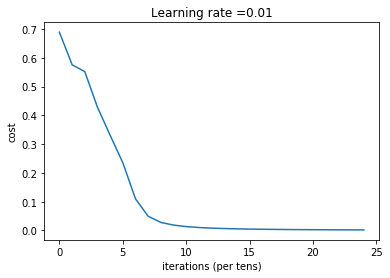

In [76]:
layers_dims = [12288, 20, 15, 10, 1] #  4-layer model
parameters = L_layers_model(train_x, train_y, layers_dims, num_iterations=2500, isPlot=True)

###### 预测  
为何准确度已经等于1了，但是cost仍然不为0？？

In [78]:
pred_train = predict(train_x, train_y, parameters) # 训练集
pred_test = predict(test_x, test_y, parameters) # 测试集

准确度为: 1.0
准确度为: 0.78


###### 测试集预测错误的原因
模型往往表现欠佳的几种类型的图像包括：  
- 猫身体在一个不同的位置
- 猫出现在相似颜色的背景下
- 不同的猫的颜色和品种
- 相机角度
- 图片的亮度
- 比例变化（猫的图像非常大或很小）

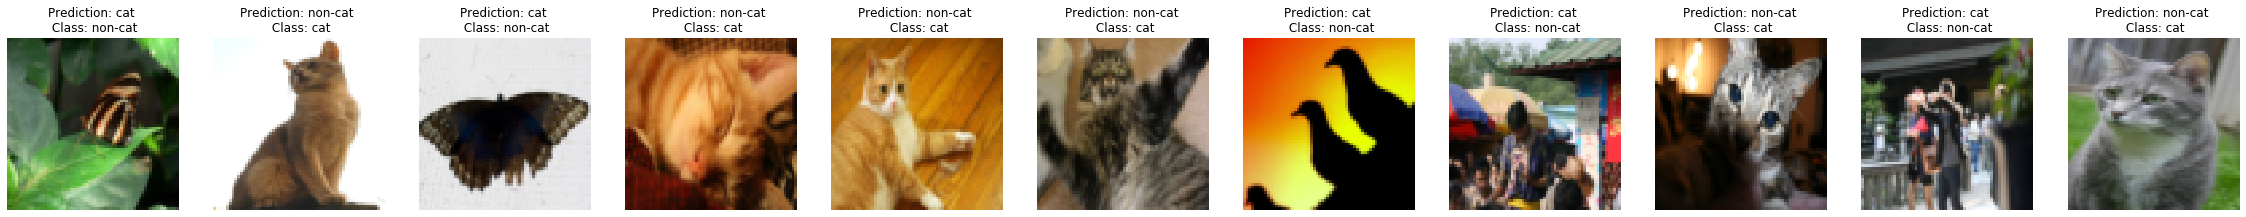

In [79]:
def print_mislabeled_images(classes, X, y, p):
    """
    绘制预测和实际不同的图像。
        X - 数据集
        y - 实际的标签
        p - 预测
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))


print_mislabeled_images(classes, test_x, test_y, pred_test)

###### 预测自己的图片

**使用scipy读取图片**  

png文件的特征长度是16384=64*64*4，所以无法被模型预测：ValueError: cannot reshape array of size 16384 into shape (12288,1)

准确度为: 1.0
y = 1.0, your L-layer model predicts a "cat"picture.


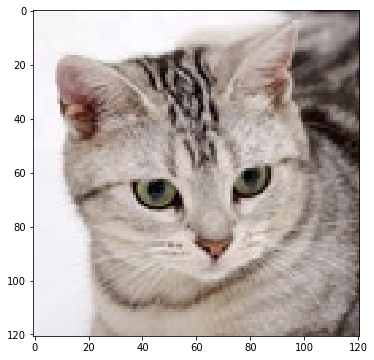

In [80]:
from scipy import ndimage, misc

my_image = 'a cat.jpg'
my_label_y = [1]

num_px = 64
image = np.array(ndimage.imread(my_image,flatten = False))

my_image = misc.imresize(image,size = (num_px,num_px)).reshape((num_px*num_px*3, 1))
    
my_predict_image = predict(my_image,my_label_y,parameters)
print("y = " + str(np.squeeze(my_predict_image)) + ", your L-layer model predicts a \"" 
      + classes[int(np.squeeze(my_predict_image))].decode("utf-8") + "\"picture.")

plt.figure(figsize=(8,6)) 
plt.imshow(image)

**使用pillow读取图像**

准确度为: 1.0
y = 1.0, your L-layer model predicts a "cat"picture.


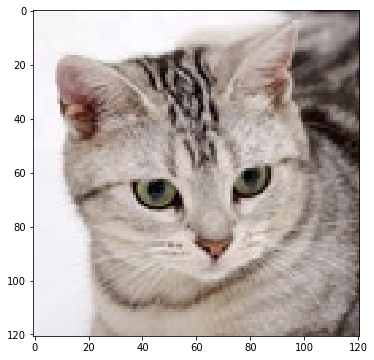

In [81]:
from PIL import Image
my_label_y = [1] 
 
num_px = 64
image = Image.open('a cat.jpg')

# 与原文不同之处，用pillow操作图片
my_image = np.array(image.resize((num_px, num_px), Image.ANTIALIAS)) 
my_image = my_image.reshape(num_px*num_px*3, -1)
 
predict_my_image = predict(my_image, my_label_y, parameters)
print("y = " + str(np.squeeze(predict_my_image)) + ", your L-layer model predicts a \"" 
      + classes[int(np.squeeze(predict_my_image))].decode("utf-8") + "\"picture.")

plt.figure(figsize=(8,6)) 
plt.imshow(image)

##### 训练其他结构的网络
###### 训练一个单层的神经网络
可以看出，学习率过大，cost出现了反弹

第 0 次迭代，成本值为： 0.6775048582584078
第 100 次迭代，成本值为： 0.4184573401927355
第 200 次迭代，成本值为： 1.7926086250283442
第 300 次迭代，成本值为： 1.0464574617691949
第 400 次迭代，成本值为： 0.7209576912675667
第 500 次迭代，成本值为： 0.4581463047384103
第 600 次迭代，成本值为： 0.24850449288414836
第 700 次迭代，成本值为： 0.1543960356180139
第 800 次迭代，成本值为： 0.1348146574792634
第 900 次迭代，成本值为： 0.12447692754921393
第 1000 次迭代，成本值为： 0.11601323415826995
第 1100 次迭代，成本值为： 0.10875687100070296
第 1200 次迭代，成本值为： 0.10239650028569475
第 1300 次迭代，成本值为： 0.09674760854886512
第 1400 次迭代，成本值为： 0.09168502168279141
第 1500 次迭代，成本值为： 0.08711652548287774
第 1600 次迭代，成本值为： 0.08297068118712829
第 1700 次迭代，成本值为： 0.07919034663496034
第 1800 次迭代，成本值为： 0.07572881847335257
第 1900 次迭代，成本值为： 0.07254732783099162
第 2000 次迭代，成本值为： 0.06961330811048838
第 2100 次迭代，成本值为： 0.06689914055661492
第 2200 次迭代，成本值为： 0.06438121495453261
第 2300 次迭代，成本值为： 0.06203920860908979
第 2400 次迭代，成本值为： 0.059855522262765214


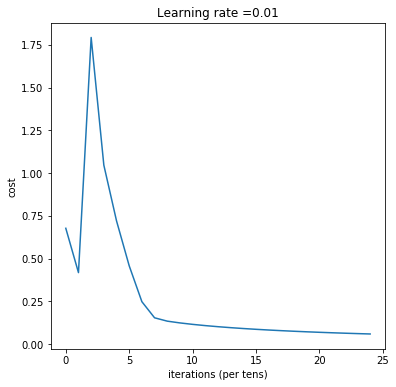

In [89]:
layers_dims = [12288, 1] #  1-layer model
parameters = L_layers_model(train_x, train_y, layers_dims, num_iterations=2500, isPlot=True)

In [90]:
pred_train = predict(train_x, train_y, parameters) # 训练集
pred_test = predict(test_x, test_y, parameters) # 测试集

准确度为: 1.0
准确度为: 0.68


降低学习率

第 0 次迭代，成本值为： 0.6775048582584078
第 100 次迭代，成本值为： 0.6382757804767129
第 200 次迭代，成本值为： 0.48191278734344906
第 300 次迭代，成本值为： 0.3768674465301761
第 400 次迭代，成本值为： 0.3316150271124403
第 500 次迭代，成本值为： 0.3031157937166248
第 600 次迭代，成本值为： 0.2795217972847422
第 700 次迭代，成本值为： 0.25955401598707584
第 800 次迭代，成本值为： 0.24236907256016013
第 900 次迭代，成本值为： 0.2273811026236004
第 1000 次迭代，成本值为： 0.2141670824226396
第 1100 次迭代，成本值为： 0.2024120160592434
第 1200 次迭代，成本值为： 0.1918753344528012
第 1300 次迭代，成本值为： 0.18236935853955244
第 1400 次迭代，成本值为： 0.17374498479234537
第 1500 次迭代，成本值为： 0.1658818787629278
第 1600 次迭代，成本值为： 0.15868158212328978
第 1700 次迭代，成本值为： 0.15206255886217057
第 1800 次迭代，成本值为： 0.14595656494712492
第 1900 次迭代，成本值为： 0.14030594107584132
第 2000 次迭代，成本值为： 0.13506156167219502
第 2100 次迭代，成本值为： 0.13018125846277742
第 2200 次迭代，成本值为： 0.12562859264322596
第 2300 次迭代，成本值为： 0.12137188680120307
第 2400 次迭代，成本值为： 0.11738345301593411


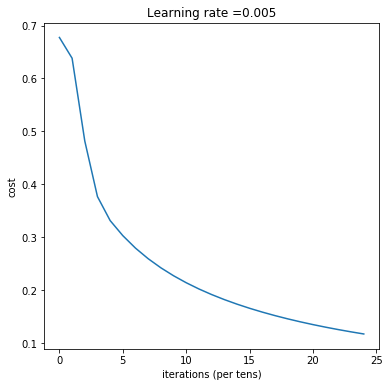

In [91]:
layers_dims = [12288, 1] #  1-layer model
parameters = L_layers_model(train_x, train_y, layers_dims, learning_rate=0.005, num_iterations=2500, isPlot=True)

In [92]:
pred_train = predict(train_x, train_y, parameters) # 训练集
pred_test = predict(test_x, test_y, parameters) # 测试集

准确度为: 0.9952153110047847
准确度为: 0.68


###### 训练一个2层的神经网络

第 0 次迭代，成本值为： 0.6961303809495705
第 100 次迭代，成本值为： 0.5244601827837885
第 200 次迭代，成本值为： 0.4077474958595954
第 300 次迭代，成本值为： 0.3559864343563975
第 400 次迭代，成本值为： 0.25593632954306866
第 500 次迭代，成本值为： 0.21768325618094653
第 600 次迭代，成本值为： 0.15659128032592343
第 700 次迭代，成本值为： 0.1133745954959137
第 800 次迭代，成本值为： 0.1006803032488568
第 900 次迭代，成本值为： 0.06691220367532903
第 1000 次迭代，成本值为： 0.0531543441172943
第 1100 次迭代，成本值为： 0.04356957116191657
第 1200 次迭代，成本值为： 0.0372335851924373
第 1300 次迭代，成本值为： 0.031787865154092654
第 1400 次迭代，成本值为： 0.02756727072120498
第 1500 次迭代，成本值为： 0.02425684192665316
第 1600 次迭代，成本值为： 0.02153334483493753
第 1700 次迭代，成本值为： 0.01928582440572681
第 1800 次迭代，成本值为： 0.0174074469709554
第 1900 次迭代，成本值为： 0.015821315508154195
第 2000 次迭代，成本值为： 0.014467732530575568
第 2100 次迭代，成本值为： 0.013302763130714943
第 2200 次迭代，成本值为： 0.012294363994434874
第 2300 次迭代，成本值为： 0.011410203120492231
第 2400 次迭代，成本值为： 0.01063434036596911


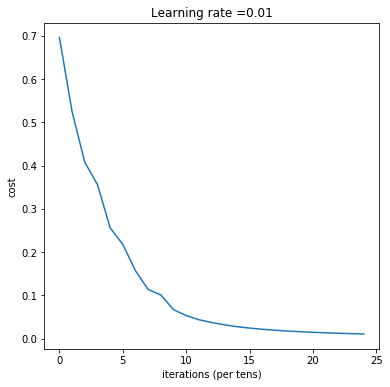

In [87]:
layers_dims = [12288, 20, 1] #  2-layer model
parameters = L_layers_model(train_x, train_y, layers_dims, num_iterations=2500, isPlot=True)

In [88]:
pred_train = predict(train_x, train_y, parameters) # 训练集
pred_test = predict(test_x, test_y, parameters) # 测试集

准确度为: 1.0
准确度为: 0.8
